## To test pull distributions

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.irf import EffectiveAreaTable2D, EnergyDispersion2D, EnergyDependentMultiGaussPSF, Background3D
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyGaussian
from gammapy.cube import make_map_exposure_true_energy
from gammapy.cube import SkyModel, MapFit, MapEvaluator


In [19]:
def get_irfs():
    filename = '$GAMMAPY_EXTRA/datasets/cta-1dc/caldb/data/cta//1dc/bcf/South_z20_50h/irf_file.fits'
    psf = EnergyDependentMultiGaussPSF.read(filename, hdu='POINT SPREAD FUNCTION')
    aeff = EffectiveAreaTable2D.read(filename, hdu='EFFECTIVE AREA')
    edisp = EnergyDispersion2D.read(filename, hdu='ENERGY DISPERSION')
    bkg = Background3D.read(filename, hdu='BACKGROUND')
    return dict(psf=psf, aeff=aeff, edisp=edisp, bkg=bkg)


In [20]:

def get_skymodel(amp):
    spatial_model = SkyGaussian(
        lon_0='0.2 deg',
        lat_0='0.1 deg',
        sigma='0.5 deg',
    )

    spectral_model = PowerLaw(
        index=3,
        amplitude=amp,
        reference='1 TeV',
    )

    sky_model = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
    )
    return sky_model


In [21]:
def simulate(evaluator, model, n_sim):
    npred = evaluator.compute_npred()
    cmap = []
    npred_map = WcsNDMap(geom, npred)
    for i in range(n_sim):
        rng = np.random.RandomState()
        counts = rng.poisson(npred)
        counts_map = WcsNDMap(geom, counts)
        cmap.append(counts_map)
    return cmap


In [57]:
def fit(cmap, exposure, model, true_model, n_sim):
    ind, ind_e, lon, lon_e = [], [], [], []
    
    for i in range(n_sim):
        
        fit = MapFit(
            model=model.copy(),
            counts=cmap[i],
            exposure=exposure,
        )

        fit.fit(opts_minuit={'print_level': 0})
        ind.append(fit.model.parameters['index'].value)
        ind_e.append(fit.minuit.errors['index'])
        lon.append(fit.model.parameters['lon_0'].value)
        lon_e.append(fit.minuit.errors['lon_0'])
    
    pull_ind = [ind - true_model.parameters['index'].value for ind in ind]
    pull_ind = np.array(pull_ind)
    ind_e = np.array(ind_e)
    pull_ind = np.divide(pull_ind,ind_e)

    
    pull_lon = [lon - true_model.parameters['lon_0'].value for lon in lon]
    pull_lon = np.array(pull_lon)
    lon_e = np.array(lon_e)
    pull_lon = np.divide(pull_lon,lon_e)
    
    index = {"mean": np.mean(ind),
             "err": np.mean(ind_e),
             "pull_mean": np.mean(pull_ind),
             "pull_std": np.std(pull_ind)}
    long = {"mean": np.mean(lon),
             "err": np.mean(lon_e),
             "pull_mean": np.mean(pull_lon),
             "pull_std": np.std(pull_lon)}

    return index,long

In [58]:
irfs = get_irfs()
# Define map geometry
axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit='TeV', name='energy'
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(9, 5),
    coordsys='GAL', axes=[axis],
)

#Observation parameters
pointing = SkyCoord(1, 0.5, unit='deg', frame='galactic')
livetime = 1 * u.hour
offset_max = 3 * u.deg
offset = Angle('2 deg')
amp = u.Quantity('1e-6 cm-2 s-1 TeV-1')

# Exposure map:
exposure = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=irfs['aeff'],
    ref_geom=geom, offset_max=offset_max)


In [59]:
index, long, amp_arr = [], [], []
for i in range(7):
    print("Running for amplitude ",amp)
    sky_model = get_skymodel(amp)
    evaluator = MapEvaluator(sky_model, exposure)   
    cmap = simulate(evaluator, sky_model, 100)
    model = get_skymodel(amp)
    amp_err = amp/10.0

    model.parameters.set_parameter_errors({
        'lon_0': '0.1 deg',
        'lat_0': '0.1 deg',
        'sigma': '0.1 deg',
        'index': '0.1',
        'amplitude': amp_err,
    })

    model.parameters['sigma'].min = 0
    model.parameters['sigma'].frozen = True
    model.parameters['lat_0'].frozen = True
    model.parameters['amplitude'].frozen = True
    
    ind, lon = fit(cmap, exposure, model, sky_model, 100)
    index.append(ind)
    long.append(lon)
    amp_arr.append(amp)
    amp = amp/10.0


Running for amplitude  1e-06 1 / (cm2 s TeV)
Running for amplitude  1e-07 1 / (cm2 s TeV)
Running for amplitude  1e-08 1 / (cm2 s TeV)
Running for amplitude  1e-09 1 / (cm2 s TeV)
Running for amplitude  1e-10 1 / (cm2 s TeV)
Running for amplitude  1.0000000000000001e-11 1 / (cm2 s TeV)
Running for amplitude  1.0000000000000002e-12 1 / (cm2 s TeV)


In [ ]:
amp_arr = [amp_arr[i].value for i in range(7)]

In [63]:
ind_pull_mean = [index[i]["pull_mean"] for i in range(7)]
ind_pull_std = [index[i]["pull_std"] for i in range(7)]
ind_mean = [index[i]["mean"] for i in range(7)]

In [64]:
lon_pull_mean = [long[i]["pull_mean"] for i in range(7)]
lon_pull_std = [long[i]["pull_std"] for i in range(7)]
lon_mean = [long[i]["mean"] for i in range(7)]

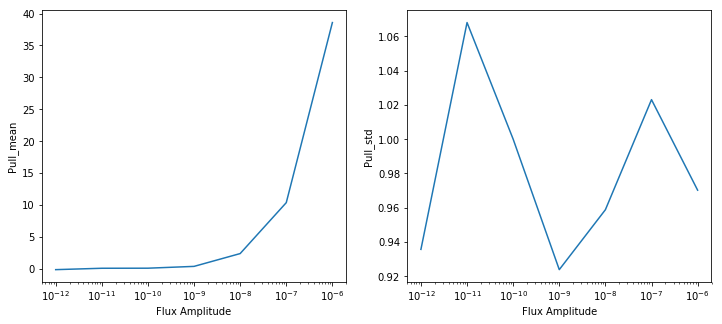

In [97]:
fig = plt.figure(figsize=(12,5))
ax1=fig.add_subplot(121)
ax1.plot(amp_arr, ind_pull_mean)
ax1.set_xlabel("Flux Amplitude")
ax1.set_ylabel("Pull_mean")
ax1.set_xscale("log")

ax2=fig.add_subplot(122)
ax2.plot(amp_arr, ind_pull_std)
ax2.set_xlabel("Flux Amplitude")
ax2.set_ylabel("Pull_std")
ax2.set_xscale("log")

